In [7]:
import numpy as np
from   scipy.sparse import spdiags, identity
from   scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline  

CENTRAL =0
FORWARD =1
BACKWARD= 2

def main():
    # Risk-free Rate
    r     = 0.03
    # Drift term
    mu = 0.02
    # Volatility coefficient
    sigma = 0.15
    # Weight of wealth placed on risky asset, (1-u) is the weight placed on risk-free asset
    u    = 0.1
    # Horizon
    T     = 20.0
    # Risk aversion term that takes on values in [0,1]
    gamma = 0.5
    Xmin  = 0.0
    Xmax  = 5.0
    # Price grid nodes
    M     = 100
    # Time grid nodes
    N     = 1600
    tol   = 1e-6
    scale = 1.0
    Umax  = 1
    # Discretization of control grid
    J     = 8

    hsigsq  = 0.5 * sigma ** 2 # half sigma squared -> 0.5 x sigma^2
    dX      = ( Xmax - Xmin ) / M
    dt      = T / N
    dXsq    = dX ** 2
    
    X    = np.linspace( Xmin, Xmax, M + 1 ) # need M+1 for there to be M steps between 0.0 and 5.0
    Us   = np.linspace( 0.0, Umax, J ) # discretize controls
    I    = identity( M + 1 )
    Gn   = np.zeros_like( X )
    Gnu1 = np.zeros_like( X )

    # Power Utility function
    terminal_values = X ** gamma / gamma
    
    def bc( t ): # boundary condition for large X_t
        tau = T - t

        e2 = np.exp( 2 * r * tau )
        delta = e2
        return  delta + delta
    
    # Check
    def alpha( X, u, dirn = CENTRAL ):
        t1 = hsigsq * (u**2) * (X**2) / dXsq
        t2 = (u * (mu - r) + r) * X
        if dirn == CENTRAL:
            return t1 - t2 / ( 2 * dX )
        elif dirn == BACKWARD:
            return t1 - t2 / dX
        elif dirn == FORWARD:
            return t1
    
    # Check
    def beta( X, u, dirn = CENTRAL ):
        t1 = hsigsq * (u**2) * (X**2) / dXsq
        t2 = (u * (mu - r) + r) * X
        if dirn == CENTRAL:
            return t1 + t2 / (2 *dX)
        elif dirn == FORWARD:
            return t1 + t2 / dX
        elif dirn == BACKWARD:
            return t1
    
    # Populating matrix A
    # Check
    def makeDiagMat( alphas, betas ):
        # Diagonal elements
        d0 = -( alphas + betas )
        # Diagonal elements below center
        dl = np.roll( alphas, -1 )
        # Diagonal elements above center
        d2 = np.roll( betas, 1 )
        d0[-1] = 0.
        dl [-2:] = 0.
        data = np.array( [ d0, dl, d2 ] )
        diags = np.array( [ 0, -1, 1 ] )
        return spdiags( data, diags, 100 + 1, 100 + 1 )
    
    def find_optima1_ctrls( Vhat, t ):
        # Inside argmin term, in our case the generator of X_t
        Fmin = np.tile( np.inf, Vhat.size )

        optdiffs = np.zeros_like( Vhat, dtype = int )
        optU    = np.zeros_like( Vhat )
        
        alphas  = np.zeros_like( Vhat ) # the final
        betas   = np.zeros_like( Vhat ) # the final
        curDiffs = np.zeros_like( Vhat, dtype = int )
        
        for u in Us: # Find the optimal control
            # Declare blank np matrix for alphas and betas
            alphas[:] = -np.inf
            betas[:] = -np.inf
            # Checks current differencing if CENTRAL, FORWARD, BACKWARD
            curDiffs[:] = CENTRAL
            
            for diff in [ CENTRAL, FORWARD, BACKWARD ]:
                a = alpha( X, u, diff)
                b = beta( X, u, diff )

                # Check if coefficients are positive for current index
                positive_coeff_indices = np.logical_and( a >= 0.0, b >= 0.0 ) == True
                positive_coeff_indices = np.logical_and( positive_coeff_indices, alphas==-np.inf )
                indices = np.where( positive_coeff_indices )

                alphas[ indices ] = a[ indices ]
                betas[ indices ] = b[ indices ]
                curDiffs[ indices ] = diff
                
            H = makeDiagMat( alphas, betas )
            F = H.dot( Vhat )
            indices = np.where( F < Fmin )
            
            Fmin[indices] = F[indices ]
            optU[indices] = u
            optdiffs[indices] = curDiffs[ indices ]
        return optU, optdiffs
    
    timesteps = np.linspace( 0.0, T, N + 1 )[:-1] # drop last item which is T=20.0
    timesteps = np.flipud( timesteps )
    V = terminal_values
    alphas = np.zeros_like( V )
    betas = np.zeros_like( V )

    # Idg this
    for t in timesteps:

        Vhat = V.copy()

        # Matrix for terminal condition of large X_t
        Gnu1[-1] = bc(t + dt)
        Gn[-1] = bc( t )
        B        = Gn - Gnu1 # new boundary cone - old boundary cone

        while True:
            ctrls, diffs = find_optima1_ctrls( Vhat, t )
            for diff in [ CENTRAL, FORWARD, BACKWARD ]:
                indices = np.where( diffs == diff )
                alphas[indices] = alpha( X[indices], ctrls[indices], diff )
                betas[indices] = beta( X[indices], ctrls[indices], diff )
                
            A   = makeDiagMat( alphas, betas )
            M = I - dt * A
            Vnew = spsolve( M, V + B )
            scale    = np.maximum( np.abs( Vnew ), np.ones_like( Vnew ) )
            residuals = np.abs( Vnew - Vhat ) / scale
            if np.all( residuals[:-1] < tol ):
                V = Vnew
                break
            else:
                Vhat = Vnew
                
    return X, V, ctrls
 
X, V, ctrls = main()

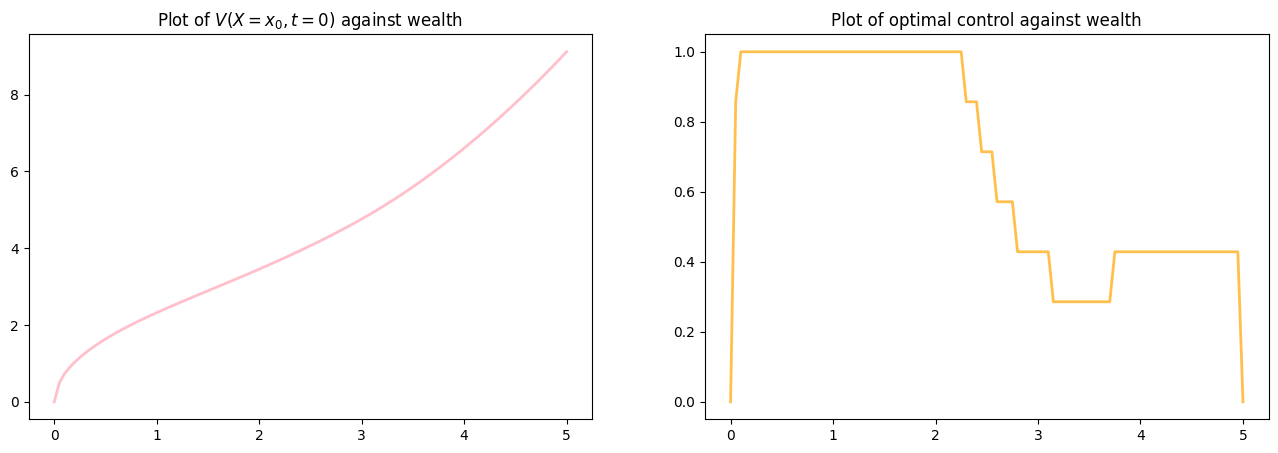

In [8]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))
ax1.plot(X, V, color = 'pink', lw=2)
ax1.set_title('Plot of $V(X=x_0, t=0)$ against wealth')
ax2.plot(X, ctrls, color = 'orange', lw=2, alpha = 0.7)
_ = ax2.set_title('Plot of optimal control against wealth')